In [56]:
import os

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

import seaborn as sns

In [45]:
def train_n_iters(X, y, n_iters=50):
    """
    Trains logistic regression model on different
    train and test sets. 
    
    Args:
        X: dataset with all obeservations. Shape (m, n)
        y: target values. Shape (m,)
        n_iters: number of iteration or number of models that 
        will be trained. Epochs is an integer
    
    Returns:
        results: Dataframe that contains f1_score, accuracy, precission, recall, true-positive, true-negative,
        false-positive, false-negative. Each row represent the ith iteration
        
        
    """
    
    
    res = pd.DataFrame()
    
    for i in range(0, n_iters+1): 
        # split data
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.55)
        # init logistic regression
        logreg = LogisticRegression()
        # fit model
        logreg.fit(X_train, y_train)
        # prediction for the current dataset
        y_pred = logreg.predict(X_test)
        # get metrics
        accuracy = accuracy_score(y_test,y_pred)
        precission = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred) 
        recall = recall_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        tp = conf_matrix[1][1] # true positive
        tn = conf_matrix[0][0] # true negative
        fp = conf_matrix[1][0] # false positive
        fn = conf_matrix[0][1] # false negative
        
        ith_row = {"accuracy": accuracy, "precision": precission, 
                   "f1_score": f1, "recall": recall, "true_positive": tp, "true_negative": tn, 
                  "false_positive": fp, "false_negative": fn}
        
        res = res.append(ith_row, ignore_index=True)
        
    return res

In [2]:
CSV_LOCATION = "peace_sys.csv"

In [4]:
df = pd.read_csv(CSV_LOCATION)

In [5]:
VARS = {'ID1.1Over' : 'Overarching Identity', 'Int2.4Hist' : 'Interconnected Historically', 
        'Int2.2Econ' : 'Interconnected Economically', 'Dep3.3Econ' : 'Interdependent Economically', 
        'Dep3.2Ecol' : 'Interdependent Ecologically', 'NWNorm5.1': 'Non-Warring Norms', 
        'NWVal4.1' : 'Non-Warring Values', 'SymP6': 'Peace Symbols', 'RitP6' : 'Peace Rituals', 
        'CM8.5Peace' : 'Peaceful Conflict Management Overall'}

In [6]:
y = df['PSysRec']

In [7]:
X = df[VARS.keys()].replace(9, np.nan)
X = X.fillna(X.mean())

In [8]:
X.head(5)

,ID1.1Over,Int2.4Hist,Int2.2Econ,Dep3.3Econ,Dep3.2Ecol,NWNorm5.1,NWVal4.1,SymP6,RitP6,CM8.5Peace
0,2.532258,2.913043,2.984375,2.689655,2.5,3.083333,3.171875,2.923077,2.565217,3.1
1,1.000000,2.913043,1.000000,3.000000,2.5,3.083333,4.000000,2.000000,2.000000,3.1
2,2.532258,2.913043,2.984375,1.000000,1.0,3.083333,2.500000,2.923077,2.565217,3.1
3,2.532258,2.913043,3.000000,3.000000,3.0,3.083333,3.000000,2.923077,2.565217,3.1
4,2.532258,4.000000,4.000000,3.000000,2.0,3.083333,3.000000,3.000000,2.565217,3.1


In [19]:
plt.savefig('confusion_matrix.pdf', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [47]:
res = train_n_iters(X, y, n_iters=100)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
res

,accuracy,f1_score,false_negative,false_positive,precision,recall,true_negative,true_positive
0,0.807692,0.705882,1.0,4.0,0.857143,0.600000,15.0,6.0
1,0.961538,0.933333,0.0,1.0,1.000000,0.875000,18.0,7.0
2,0.807692,0.736842,3.0,2.0,0.700000,0.777778,14.0,7.0
3,0.923077,0.857143,0.0,2.0,1.000000,0.750000,18.0,6.0
4,0.923077,0.888889,1.0,1.0,0.888889,0.888889,16.0,8.0
...,...,...,...,...,...,...,...,...
96,0.923077,0.833333,0.0,2.0,1.000000,0.714286,19.0,5.0
97,0.846154,0.777778,1.0,3.0,0.875000,0.700000,15.0,7.0
98,0.807692,0.736842,4.0,1.0,0.636364,0.875000,14.0,7.0
99,0.961538,0.933333,0.0,1.0,1.000000,0.875000,18.0,7.0


In [69]:
mean_f1_score = np.round(res['f1_score'].mean(), 3) 
mean_accuracy_score = np.round(res['accuracy'].mean(), 3)
mean_precision_score = np.round(res['precision'].mean(), 3)
mean_recall_score = np.round(res['recall'].mean(), 3) 

In [70]:
print("Mean F1 Score: " + str(mean_f1_score))
print("Mean Accuracy: " + str(mean_accuracy_score))
print("Mean Precision: " + str(mean_precision_score))
print("Mean Recall: " + str(mean_recall_score))

Mean F1 Score: 0.776
Mean Accuracy: 0.865
Mean Precision: 0.925
Mean Recall: 0.701


In [59]:
mean_tn = np.round(res['true_negative'].mean(), 3)
mean_tp = np.round(res['true_positive'].mean(), 3)
mean_fn = np.round(res['false_negative'].mean(), 3)
mean_fp = np.round(res['false_positive'].mean(), 3)

In [60]:
mean_conf_matrix = [[mean_tn, mean_fn], [mean_fp, mean_tp]]

In [61]:
mean_conf_matrix

[[16.297, 0.644], [2.861, 6.198]]

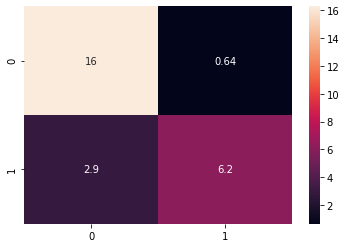

In [71]:
mean_conf_matrix_plot = sns.heatmap(mean_conf_matrix, annot=True)

In [72]:
# save confusion matrix
mean_conf_matrix_plot.get_figure().savefig("mean_confusion_matrix.png")

In [89]:
mean_metrics = {
"Metrics": {   "f1_score": mean_f1_score, "accuracy": mean_accuracy_score,
    "precision": mean_precision_score, "recall": mean_recall_score}
}

In [93]:
mean_metrics = pd.DataFrame({
    "Metric": ['F1 Score', 'Precission', 'Recall', 'Accuracy'], 
    "Score": [mean_f1_score, mean_precision_score, mean_recall_score, mean_accuracy_score]
})

In [98]:
metric_names = ['F1 Score', 'Precission', 'Recall', 'Accuracy']
mean_scores = [mean_f1_score, mean_precision_score, mean_recall_score, mean_accuracy_score]

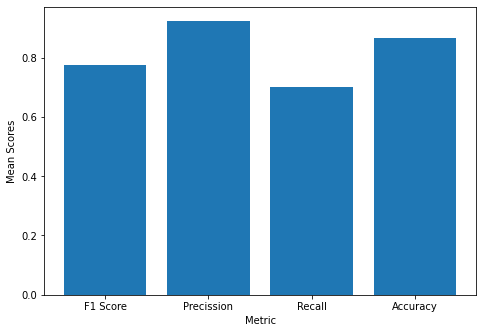

In [102]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(metric_names, mean_scores)
plt.ylabel('Mean Scores')
plt.xlabel('Metric')
plt.show()

In [103]:
fig.savefig('mean_metric_scores.png')